# MILB - Great Lakes Loons Retention Checkup

* StellarAlgo
* Ryan Kazmerik
* August 2, 2022

In [61]:
import boto3 
import json
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from pycaret.classification import *
from shared_utilities import helpers

In [45]:
from importlib import reload
reload(helpers)

<module 'shared_utilities.helpers' from '/Users/ryankazmerik/Git/data-sci/shared_utilities/shared_utilities/helpers.py'>

### Login to AWS SSO profile:

In [7]:
! aws sso login --profile Explore-US-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

CLDH-KVDN
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


### Get a connection to MSSQL and get retention dataset for training & inference:

In [41]:
cnxn = helpers.get_mssql_connection('qa', 'stlrmilb')

df_train, df_eval, df_inference = helpers.get_retention_datasets(cnxn, 20)

Data for Modeling: (6919, 15)
Data For Evaluation: (2403, 15)
Data For Predictions: (1182, 15)



### Setup the Pycaret model for retention classification:

In [52]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8092,0.8451,0.9133,0.8058,0.8561,0.5762,0.5865,0.2650


### Use the model to make predictions on the 2022 season:

In [71]:
df_predictions = predict_model(best_model, data=df_inference, raw_score=True)
df_predictions.head()

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,300577574,2022,Full Season,60.0,2022-05-08,1.0,6,365,3220,22.96,0,0,0,0,0,0,0.8885,0.1115
1,300577591,2022,Full Season,42.0,2022-05-21,1.0,11,365,1070,29.17,0,0,0,0,0,0,0.8020,0.1980
2,303998561,2022,Full Season,12.0,2022-06-14,1.0,0,365,3218,35.27,0,0,0,0,0,0,0.9481,0.0519
3,304347955,2022,Full Season,60.0,1970-01-01,0.0,10,365,417,3.99,0,0,0,0,0,1,0.4896,0.5104
4,305248094,2022,Full Season,30.0,2022-07-02,0.8,0,365,2560,39.03,0,1,0,0,0,0,0.9774,0.0226


### Let's examine the number of buyers vs. non-buyers and look at the distribution of scores:

In [72]:
print(f"No. predicted non-buyers: {df_predictions['Label'].value_counts()[0]}")
print(f"No. predicted buyers: {df_predictions['Label'].value_counts()[1]}")

No. predicted non-buyers: 863
No. predicted buyers: 319


Text(0.5, 0, 'SA Buyer Score')

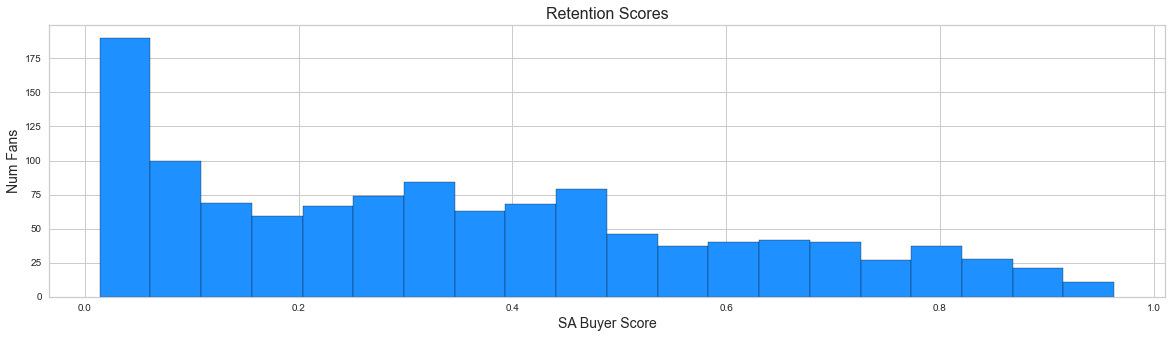

In [73]:
fig = plt.figure(figsize=(20, 5))

plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black', color='dodgerblue')
plt.title("Retention Scores", fontsize=16)
plt.ylabel("Num Fans", fontsize=14)
plt.xlabel("SA Buyer Score", fontsize=14)

### Done